# Benchmarking the lie detection classifiers against each other

### Setup

In [1]:
import numpy as np
import torch
import pandas as pd

import os
from collections import defaultdict
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'   # better inline figure resolution

# repository imports
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, compute_average_accuracies, show_and_save_results, load_results
from probes import CCSProbe, TTPD, LRProbe, MMProbe, SimpleMLPProbe

/tmp/ipykernel_423320/4046330291.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Hyperparameters

In [2]:
# model info - to specifiy which (pre-computed) activations to use
    # currently available options: 
    # - Llama3, 8B, chat, layer 12
    # - Gemma2, 9B, base, layer 16
    # - Mistral, 7B, chat, layer 13
model_family = 'Mistral'
model_size = '7B'
model_type = 'chat'
layer = 13   # layer from which to extract activations

# general experimt info - for saving the experiment results and plots
notebook_name = 'lie_detection'
model_name = f"{model_family}_{model_size}_{model_type}"

# classifier info - for training the probes
probe_types = [SimpleMLPProbe, TTPD, LRProbe, MMProbe, CCSProbe,]
probe_names = [p.__name__ for p in probe_types]
probe_names_short = ['MLP', 'TTPD', 'LR', 'MM', 'CCS']
train_sets = [
    "cities", "neg_cities", 
    "sp_en_trans", "neg_sp_en_trans", 
    "inventors", "neg_inventors", 
    "animal_class", "neg_animal_class", 
    "element_symb", "neg_element_symb", 
    "facts", "neg_facts"
]   # len = 12
train_set_sizes = dataset_sizes(train_sets)   # get size of each training dataset to include an equal number of statements from each topic in training data

# hardware info
   # gpu speeds up CCS training a fair bit but is not required
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Testing generalization to unseen topics

In [3]:
# Experiment hyperparameters
experiment_name = "unseen_topics"
validation_type = "leave-one-out cross-validation"
val_sets = train_sets
num_iter = 20   # number of times the probes are trained and evaluated on the same datasets

Either 
- a) load saved experimental results or 
- b) run a new training.

##### Train the probes

In [4]:
# Training and evaluating classifiers
    
## create an empty dictionary to store the results for each probe type
results = {probe:defaultdict(list) for probe in probe_names}
total_iterations = len(probe_names) * num_iter * len(train_sets)

## Iterate over each probe type and number of iterations
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_name in probe_names:
        for n in range(num_iter):
            indices = np.arange(0, 12, 2)   # indices of the datasets to be used for training
            
            # leave-one-out cross-validation training
            for i in indices:
                # leave out datasets i (aff.) and i+1 (neg.) for training
                cv_train_sets = np.delete(np.array(train_sets), [i, i+1], axis=0)
                
                # load training data
                acts_centered, acts, labels, polarities = collect_training_data(cv_train_sets, train_set_sizes, model_family, model_size, model_type, layer)
                
                # train classifier
                if probe_name == "TTPD":
                    probe = TTPD.from_data(acts_centered, acts, labels, polarities)
                if probe_name == "LRProbe":
                    probe = LRProbe.from_data(acts, labels)
                if probe_name == "CCSProbe":
                    acts_affirm = acts[polarities == 1.0]
                    acts_neg = acts[polarities == -1.0]
                    labels_affirm = labels[polarities == 1.0]
                    mean_affirm = torch.mean(acts_affirm, dim=0) 
                    mean_neg = torch.mean(acts_neg, dim=0)
                    acts_affirm = acts_affirm - mean_affirm
                    acts_neg = acts_neg - mean_neg
                    probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
                if probe_name == "MMProbe":
                    probe = MMProbe.from_data(acts, labels)
                if probe_name == "SimpleMLPProbe":
                    probe = SimpleMLPProbe.from_data(acts, labels, polarities)

                # evaluate classification accuracy on held out datasets
                dm = DataManager()
                for j in range(0,2):
                    dm.add_dataset(train_sets[i+j], model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[train_sets[i+j]]
                    
                    # classifier specific predictions
                    if probe_name == "CCSProbe":
                        if j == 0:
                            acts = acts - mean_affirm
                        if j == 1:
                            acts = acts - mean_neg
                    predictions = probe.pred(acts)
                    
                    results[probe_name][train_sets[i+j]].append((predictions == labels).float().mean().item())
                    pbar.update(1)

Training and evaluating classifiers:   0%|          | 0/1200 [00:00<?, ?it/s]

Training and evaluating classifiers: 100%|██████████| 1200/1200 [12:08<00:00,  1.65it/s]


In [5]:
# Compute and save summary statistics

probe_accuracies = compute_average_accuracies(results, num_iter)   # overall accuracies for each probe type
dataset_accuracies = compute_statistics(results)  # accuracies for each probe type and validation dataset
meta_info = {
    'notebook_name': notebook_name,
    'model_name': model_name,
    'layer': layer,
    'experiment_name': experiment_name,
    'probe_names': probe_names,
    'validation_type': validation_type,
    'num_iterations': num_iter,
    'train_sets': train_sets,
    'val_sets': val_sets,    
}   # Create a dictionary with meta information

show_and_save_results(probe_accuracies, dataset_accuracies, meta_info, save=True)

Results for the experiment 'unseen_topics' and the model 'Mistral_7B_chat' (layer 13):
    mean accuracy ± std deviation
------------------------------------
SimpleMLPProbe      : 87.9 ±  3.5%
TTPD                : 93.6 ±  0.2%
LRProbe             : 94.1 ±  1.0%
MMProbe             : 87.7 ±  0.7%
CCSProbe            : 87.0 ±  6.5%
------------------------------------

Results saved to ./results/lie_detection--unseen_topics--Mistral_7B_chat.json


##### Plot a grid of accuracies for each probe type and validation dataset.

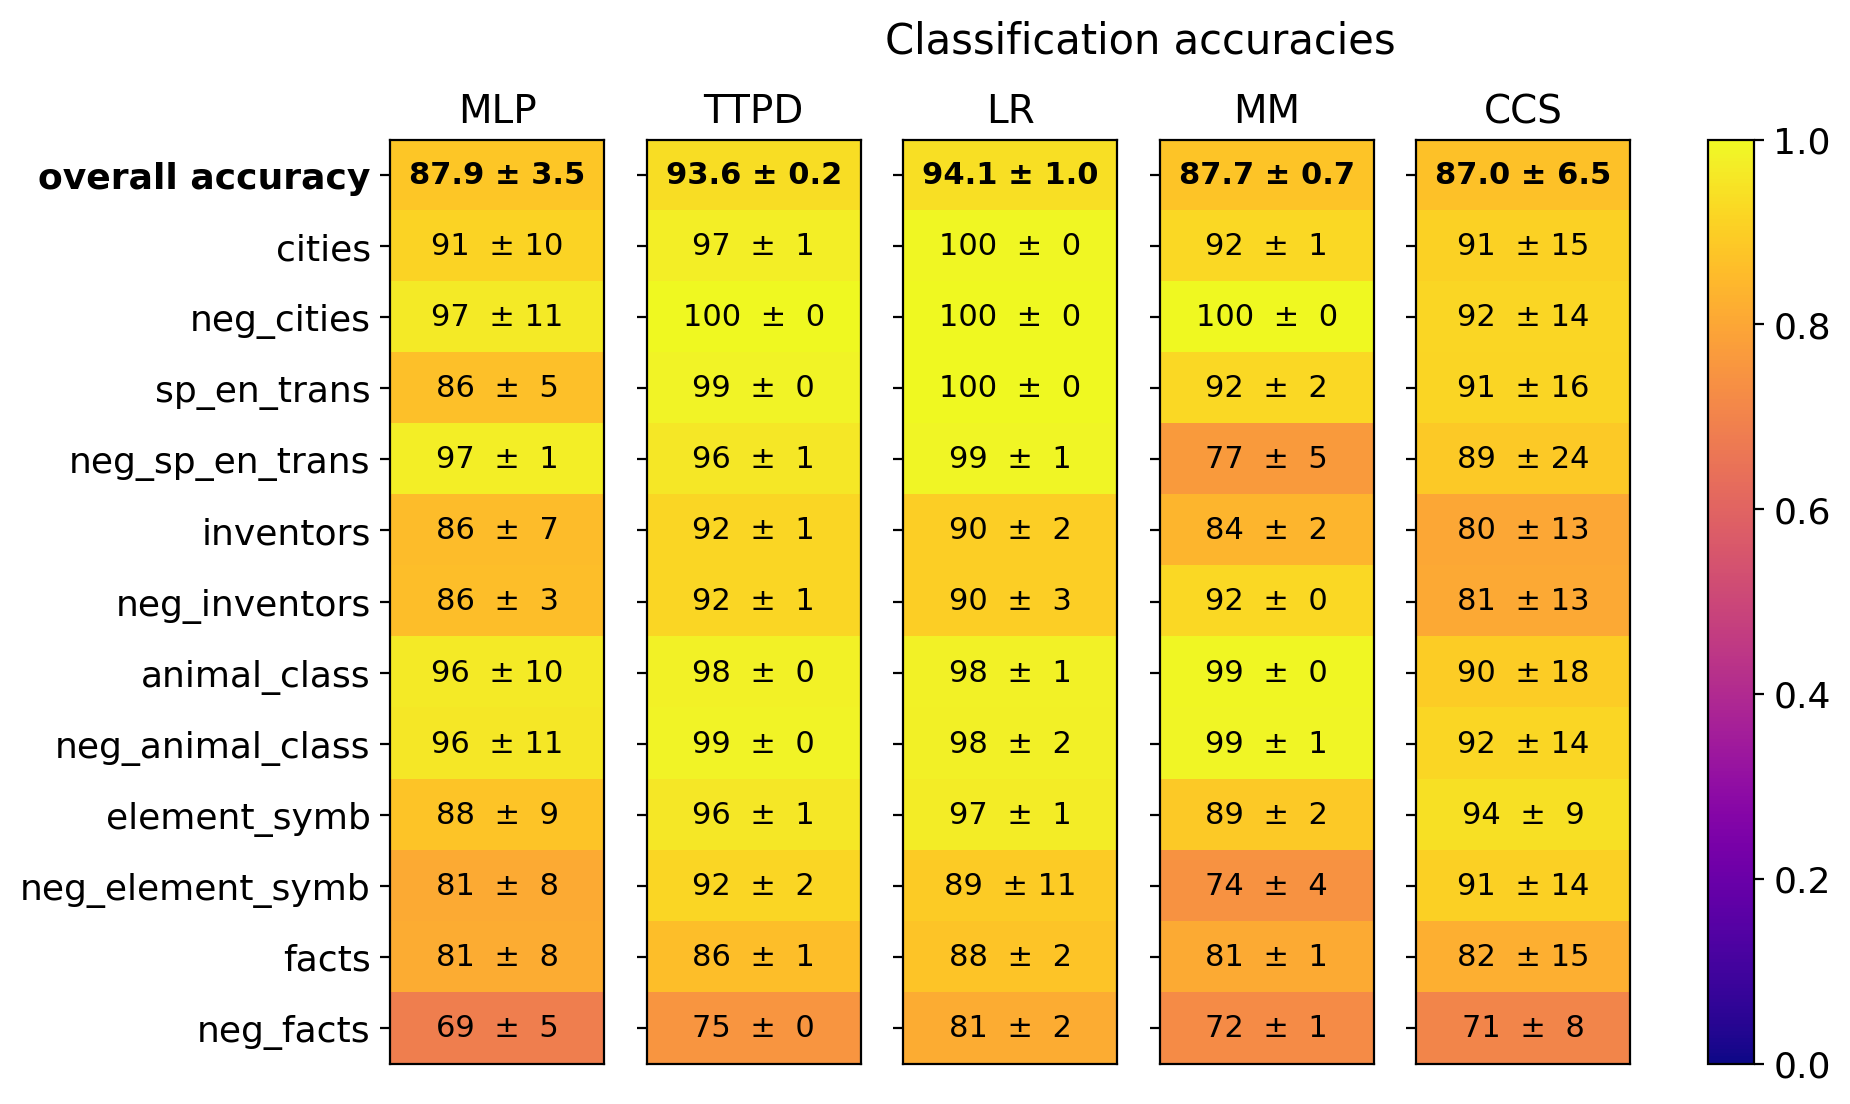

In [6]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=len(probe_names))
fig.suptitle("Classification accuracies", fontsize=15)

# build the overall‐accuracy lists once
overall_means = [probe_accuracies[probe]['mean'] for probe in probe_names]
overall_stds  = [probe_accuracies[probe]['std_dev']  for probe in probe_names]

for t, (ax, key) in enumerate(zip(axes, probe_names)):
    # build the per‐dataset grid
    grid = [[dataset_accuracies[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[dataset_accuracies[key]['std'][dataset]] for dataset in val_sets]
    
    # insert the "overall" row at the top
    grid.insert(0, [overall_means[t]])
    grid_std.insert(0, [overall_stds[t]])

    # draw it
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # annotate
    for i, row in enumerate(grid):
        for j in range(len(row)):
            val = grid[i][j]
            std = grid_std[i][j]
            if i == 0:
                text = f"{val*100:3.1f} ± {std*100:3.1f}"
                weight = 'bold'
            else:
                text = f"{val*100:2.0f}  ± {std*100:2.0f}"
                weight = 'normal'
            ax.text(j, i, text, ha='center', va='center', fontsize=11, fontweight=weight)
    
    # ticks and titles
    ax.set_title(probe_names_short[t], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks(range(len(grid)))
    ax.set_yticklabels([])

# label the y‐axis on the first column only
yticks = ["overall accuracy"] + val_sets
axes[0].set_yticklabels(yticks, fontsize=13)
for label in axes[0].get_yticklabels():
    if label.get_text() == "overall accuracy":
        label.set_fontweight("bold")
    else:
        label.set_fontweight("normal")

# colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.ax.tick_params(labelsize=13)

# save the figure
plt.savefig(f"./results/{notebook_name}--{experiment_name}--{model_name}.svg", bbox_inches = "tight")

### Generalization to logical conjunctions and disjunctions

In [7]:
# Experimental hyperparameters
experiment_name = "logical_junctions"
validation_type = "separate validation sets"
val_sets = [
    "cities_conj", "cities_disj", 
    "sp_en_trans_conj","sp_en_trans_disj",
    "inventors_conj", "inventors_disj", 
    "animal_class_conj", "animal_class_disj",
    "element_symb_conj", "element_symb_disj", 
    "facts_conj", "facts_disj",
    "common_claim_true_false", "counterfact_true_false"
]
num_iter = 20
total_iterations = len(probe_types) * num_iter


Either 
- a) load saved experimental results or 
- b) run a new training.

##### Train the probes

In [8]:
# Training and evaluating classifiers
    
## create an empty dictionary to store the results for each probe type
results = {probe:defaultdict(list) for probe in probe_names}   
total_iterations = len(probe_names) * num_iter

## Iterate over each probe type and number of iterations
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_name in probe_names:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer)

            # train classifier
            if probe_name == "TTPD":
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_name == "LRProbe":
                probe = LRProbe.from_data(acts, labels)
            if probe_name == "CCSProbe":
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_name == "MMProbe":
                probe = MMProbe.from_data(acts, labels)
            if probe_name == "SimpleMLPProbe":
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_name == "CCSProbe":
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_name][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers:   0%|          | 0/100 [00:00<?, ?it/s]

Training and evaluating classifiers: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


In [9]:
# Compute and save summary statistics

probe_accuracies = compute_average_accuracies(results, num_iter)   # overall accuracies for each probe type
dataset_accuracies = compute_statistics(results)  # accuracies for each probe type and validation dataset
meta_info = {
    'notebook_name': notebook_name,
    'model_name': model_name,
    'layer': layer,
    'experiment_name': experiment_name,
    'probe_names': probe_names,
    'validation_type': validation_type,
    'num_iterations': num_iter,
    'train_sets': train_sets,
    'val_sets': val_sets,    
}   # Create a dictionary with meta information

show_and_save_results(probe_accuracies, dataset_accuracies, meta_info, save=True)

Results for the experiment 'logical_junctions' and the model 'Mistral_7B_chat' (layer 13):
    mean accuracy ± std deviation
------------------------------------
SimpleMLPProbe      : 64.6 ±  5.4%
TTPD                : 72.6 ±  0.4%
LRProbe             : 68.7 ±  1.8%
MMProbe             : 70.1 ±  1.1%
CCSProbe            : 67.9 ±  4.8%
------------------------------------

Results saved to ./results/lie_detection--logical_junctions--Mistral_7B_chat.json


##### Plot a grid of accuracies for each probe type and validation dataset.

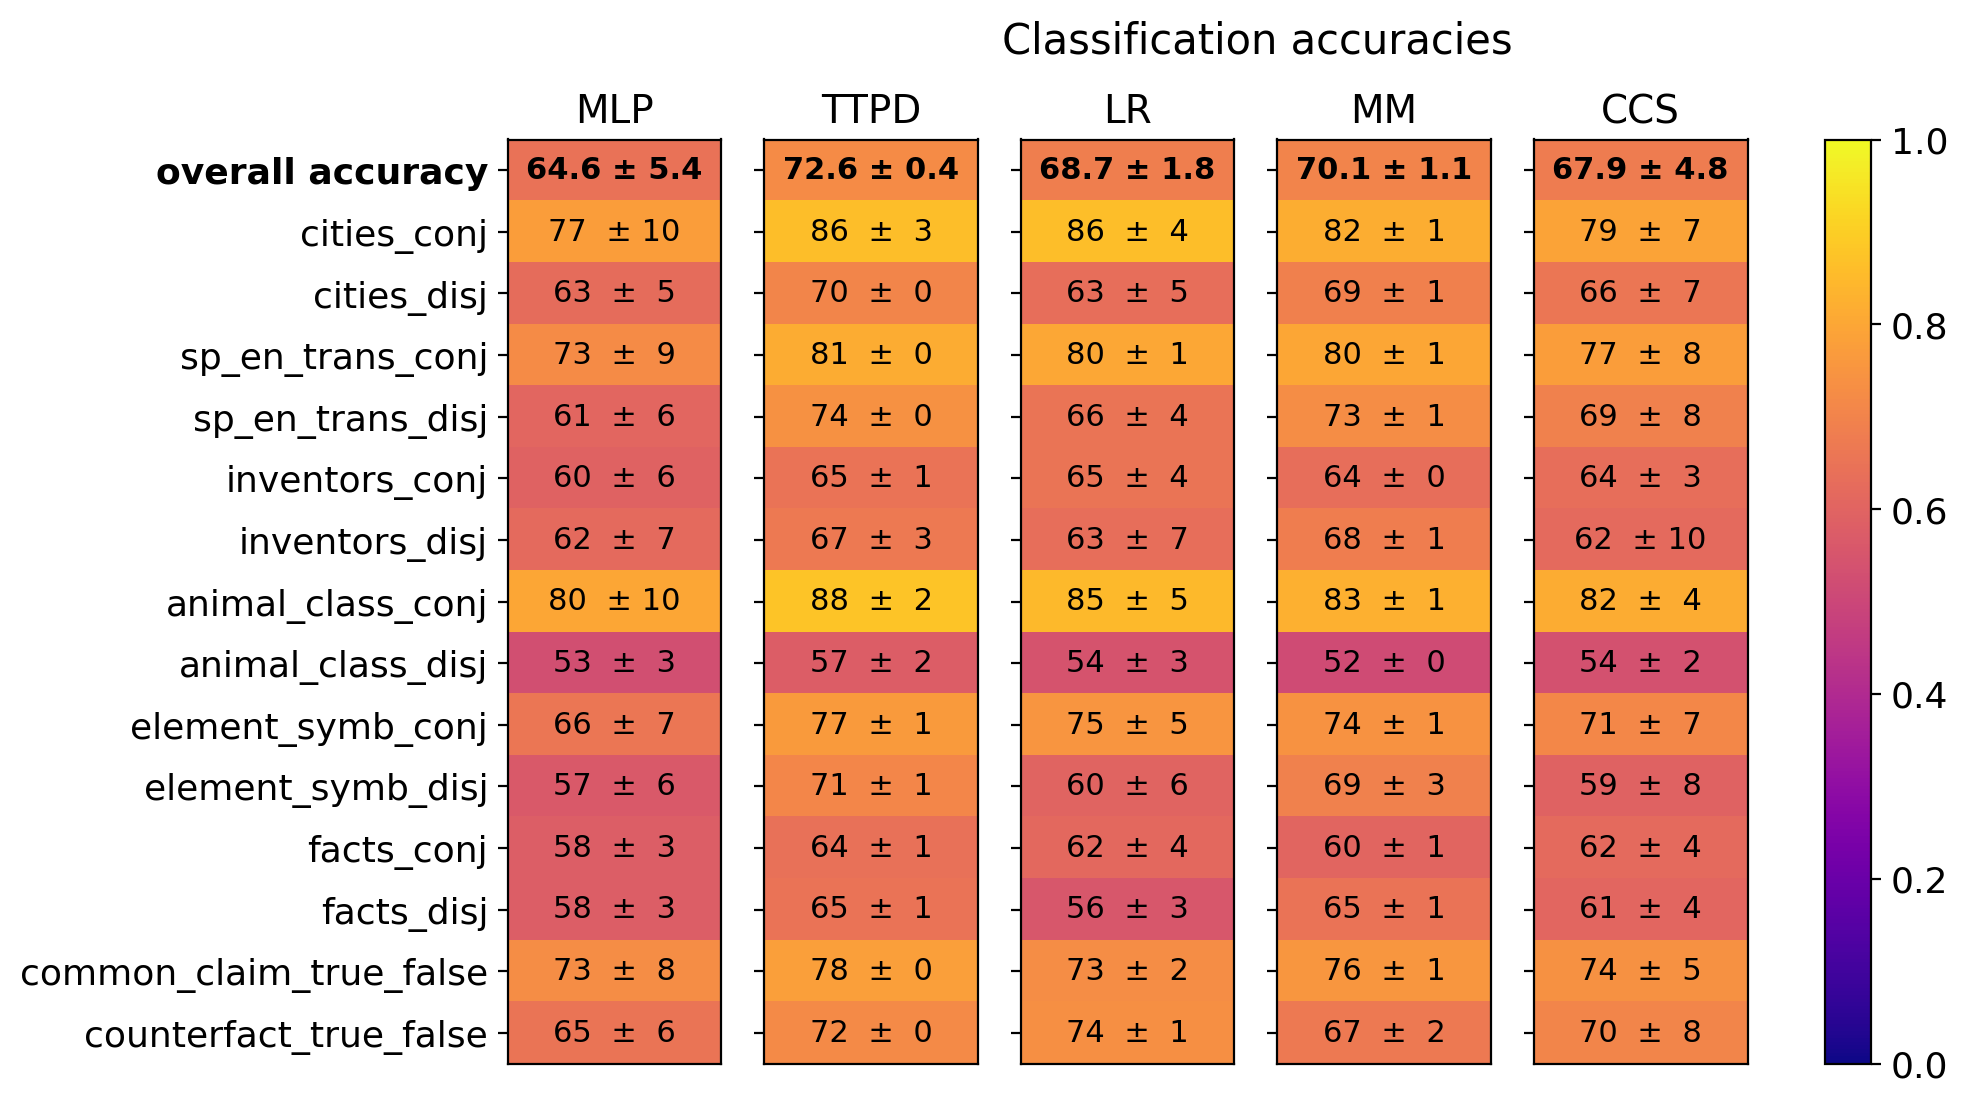

In [10]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=len(probe_names))
fig.suptitle("Classification accuracies", fontsize=15)

# build the overall‐accuracy lists once
overall_means = [probe_accuracies[probe]['mean'] for probe in probe_names]
overall_stds  = [probe_accuracies[probe]['std_dev']  for probe in probe_names]

for t, (ax, key) in enumerate(zip(axes, probe_names)):
    # build the per‐dataset grid
    grid = [[dataset_accuracies[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[dataset_accuracies[key]['std'][dataset]] for dataset in val_sets]
    
    # insert the "overall" row at the top
    grid.insert(0, [overall_means[t]])
    grid_std.insert(0, [overall_stds[t]])

    # draw it
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # annotate
    for i, row in enumerate(grid):
        for j in range(len(row)):
            val = grid[i][j]
            std = grid_std[i][j]
            if i == 0:
                text = f"{val*100:3.1f} ± {std*100:3.1f}"
                weight = 'bold'
            else:
                text = f"{val*100:2.0f}  ± {std*100:2.0f}"
                weight = 'normal'
            ax.text(j, i, text, ha='center', va='center', fontsize=11, fontweight=weight)
    
    # ticks and titles
    ax.set_title(probe_names_short[t], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks(range(len(grid)))
    ax.set_yticklabels([])

# label the y‐axis on the first column only
yticks = ["overall accuracy"] + val_sets
axes[0].set_yticklabels(yticks, fontsize=13)
for label in axes[0].get_yticklabels():
    if label.get_text() == "overall accuracy":
        label.set_fontweight("bold")
    else:
        label.set_fontweight("normal")

# colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.ax.tick_params(labelsize=13)

# save the figure
plt.savefig(f"./results/{notebook_name}--{experiment_name}--{model_name}.svg", bbox_inches = "tight")

### Generalization to German statements
Compare all probes on statements translated to German.

In [11]:
# Experiment hyperparameters
experiment_name = "german"
validation_type = "separate validation sets"
val_sets = [
    "cities_de", "neg_cities_de", 
    "sp_en_trans_de", "neg_sp_en_trans_de", 
    "inventors_de", "neg_inventors_de", 
    "animal_class_de", "neg_animal_class_de", 
    "element_symb_de", "neg_element_symb_de", 
    "facts_de", "neg_facts_de"
]   # len = 12
num_iter = 20   # number of times the probes are trained and evaluated on the same datasets

Either 
- a) load saved experimental results or 
- b) run a new training.

##### Train the probes

In [12]:
# Training and evaluating classifiers
    
## create an empty dictionary to store the results for each probe type
results = {probe:defaultdict(list) for probe in probe_names}
total_iterations = len(probe_types) * num_iter

## Iterate over each probe type and number of iterations
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_name in probe_names:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer)
            
            # train classifier
            if probe_name == "TTPD":
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_name == "LRProbe":
                probe = LRProbe.from_data(acts, labels)
            if probe_name == "CCSProbe":
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_name == "MMProbe":
                probe = MMProbe.from_data(acts, labels)
            if probe_name == "SimpleMLPProbe":
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_name == "CCSProbe":
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_name][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers:   0%|          | 0/100 [00:00<?, ?it/s]

Training and evaluating classifiers: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


In [13]:
# Compute and save summary statistics

probe_accuracies = compute_average_accuracies(results, num_iter)   # overall accuracies for each probe type
dataset_accuracies = compute_statistics(results)  # accuracies for each probe type and validation dataset
meta_info = {
    'notebook_name': notebook_name,
    'model_name': model_name,
    'layer': layer,
    'experiment_name': experiment_name,
    'probe_names': probe_names,
    'validation_type': validation_type,
    'num_iterations': num_iter,
    'train_sets': train_sets,
    'val_sets': val_sets,    
}   # Create a dictionary with meta information

show_and_save_results(probe_accuracies, dataset_accuracies, meta_info, save=True)

Results for the experiment 'german' and the model 'Mistral_7B_chat' (layer 13):
    mean accuracy ± std deviation
------------------------------------
SimpleMLPProbe      : 77.7 ±  6.4%
TTPD                : 83.9 ±  0.4%
LRProbe             : 86.0 ±  1.2%
MMProbe             : 77.9 ±  0.9%
CCSProbe            : 78.4 ± 10.7%
------------------------------------

Results saved to ./results/lie_detection--german--Mistral_7B_chat.json


##### Plot a grid of accuracies for each probe type and validation dataset.

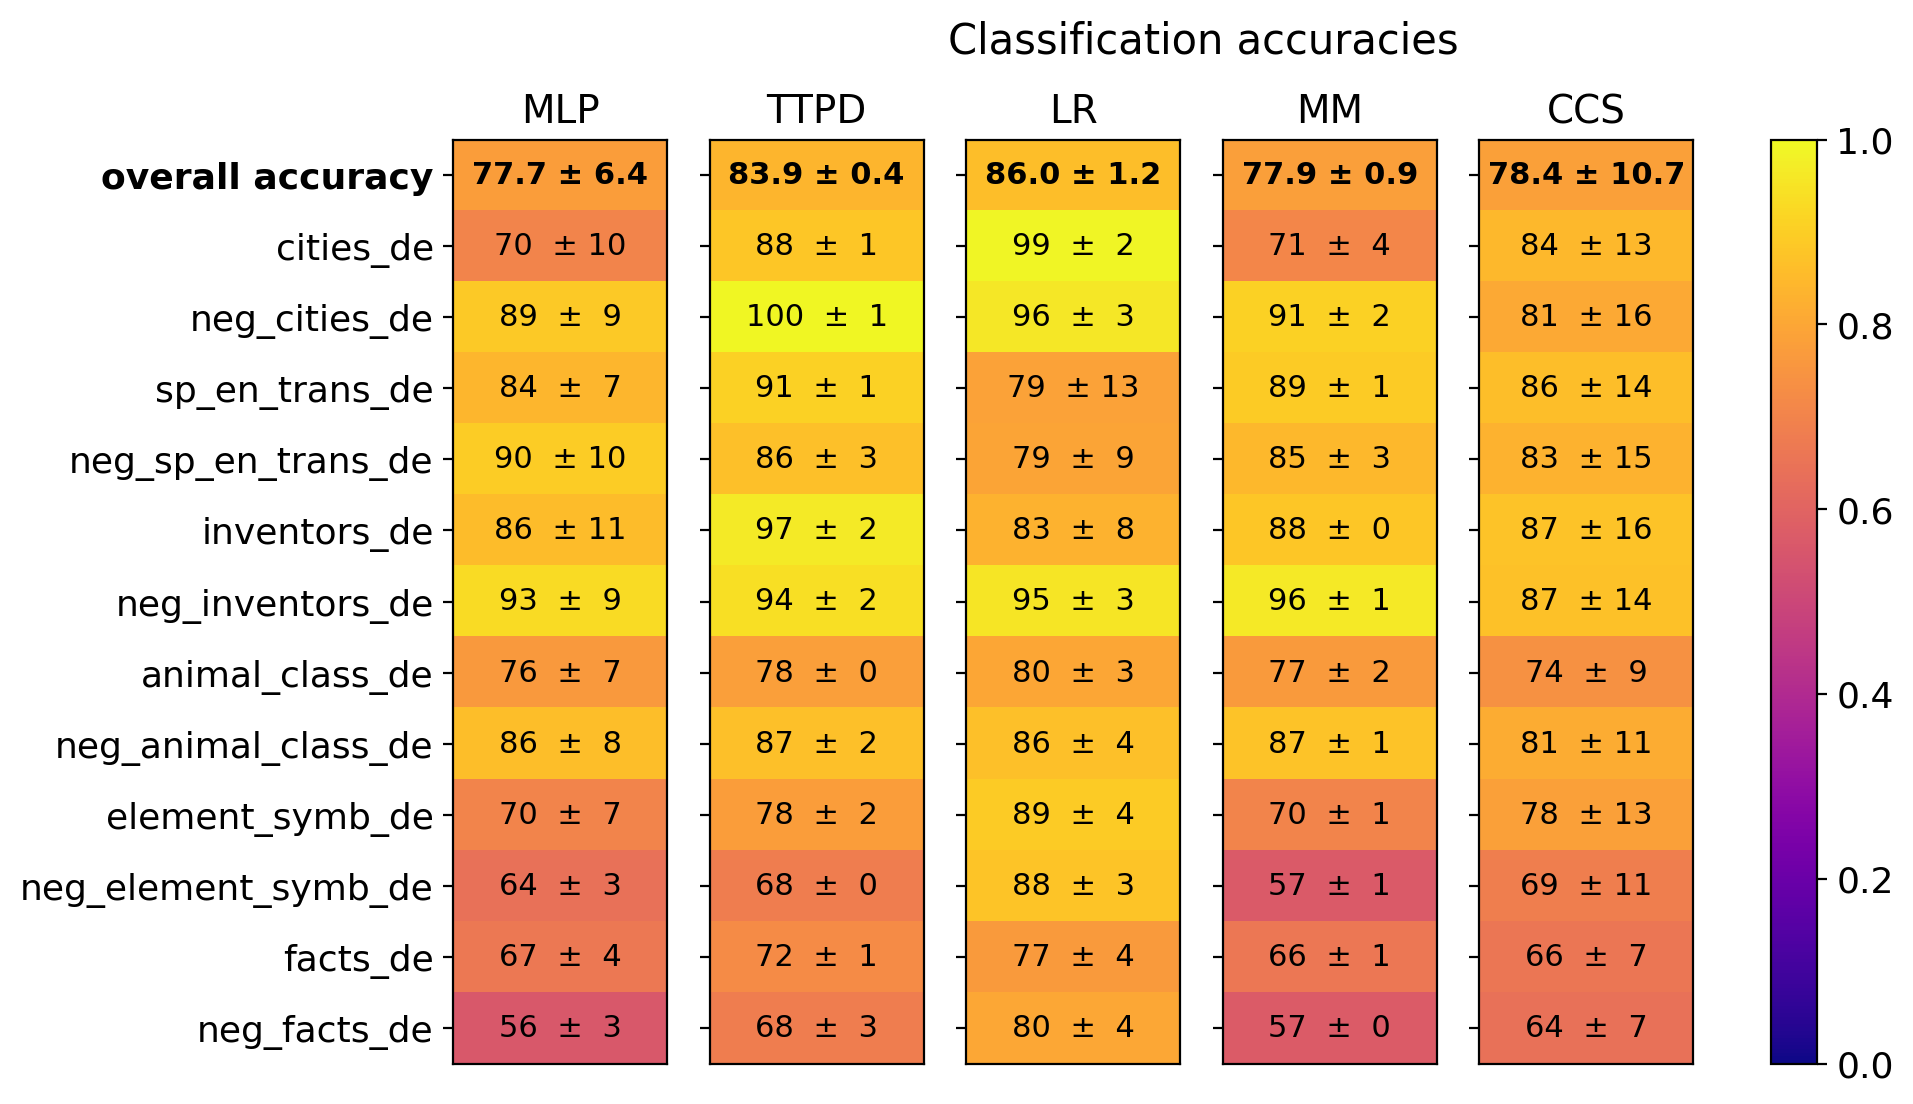

In [14]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=len(probe_names))
fig.suptitle("Classification accuracies", fontsize=15)

# build the overall‐accuracy lists once
overall_means = [probe_accuracies[probe]['mean'] for probe in probe_names]
overall_stds  = [probe_accuracies[probe]['std_dev']  for probe in probe_names]

for t, (ax, key) in enumerate(zip(axes, probe_names)):
    # build the per‐dataset grid
    grid = [[dataset_accuracies[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[dataset_accuracies[key]['std'][dataset]] for dataset in val_sets]
    
    # insert the "overall" row at the top
    grid.insert(0, [overall_means[t]])
    grid_std.insert(0, [overall_stds[t]])

    # draw it
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # annotate
    for i, row in enumerate(grid):
        for j in range(len(row)):
            val = grid[i][j]
            std = grid_std[i][j]
            if i == 0:
                text = f"{val*100:3.1f} ± {std*100:3.1f}"
                weight = 'bold'
            else:
                text = f"{val*100:2.0f}  ± {std*100:2.0f}"
                weight = 'normal'
            ax.text(j, i, text, ha='center', va='center', fontsize=11, fontweight=weight)
    
    # ticks and titles
    ax.set_title(probe_names_short[t], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks(range(len(grid)))
    ax.set_yticklabels([])

# label the y‐axis on the first column only
yticks = ["overall accuracy"] + val_sets
axes[0].set_yticklabels(yticks, fontsize=13)
for label in axes[0].get_yticklabels():
    if label.get_text() == "overall accuracy":
        label.set_fontweight("bold")
    else:
        label.set_fontweight("normal")

# colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.ax.tick_params(labelsize=13)

# save the figure
plt.savefig(f"./results/{notebook_name}--{experiment_name}--{model_name}.svg", bbox_inches = "tight")

### Displaying generalization to Conjunctions, Disjunctions and German statements in one table

In [15]:
# Experiment hyperparameters
experiment_name = "overall_generalization"
validation_type = "separate validation sets"
val_sets = [
    "cities_conj", "cities_disj", 
    "sp_en_trans_conj","sp_en_trans_disj",
    "inventors_conj", "inventors_disj", 
    "animal_class_conj", "animal_class_disj",
    "element_symb_conj", "element_symb_disj", 
    "facts_conj", "facts_disj", 
    "cities_de", "neg_cities_de", 
    "sp_en_trans_de", "neg_sp_en_trans_de", 
    "inventors_de", "neg_inventors_de", 
    "animal_class_de", "neg_animal_class_de", 
    "element_symb_de", "neg_element_symb_de", 
    "facts_de", "neg_facts_de", 
    "common_claim_true_false", "counterfact_true_false"
]   # len = 26
num_iter = 20   # number of times the probes are trained and evaluated on the same datasets

Either 
- a) load saved experimental results or 
- b) run a new training.

##### Train the probes

In [16]:
# Training and evaluating classifiers
    
## create an empty dictionary to store the results for each probe type
results = {probe:defaultdict(list) for probe in probe_names}
total_iterations = len(probe_names) * num_iter

## Iterate over each probe type and number of iterations
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar:
    for probe_name in probe_names:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer)
            
            # train classifier
            if probe_name == "TTPD":
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_name == "LRProbe":
                probe = LRProbe.from_data(acts, labels)
            if probe_name == "CCSProbe":
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_name == "MMProbe":
                probe = MMProbe.from_data(acts, labels)
            if probe_name == "SimpleMLPProbe":
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_name == "CCSProbe":
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_name][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers:   0%|          | 0/100 [00:00<?, ?it/s]

Training and evaluating classifiers: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


In [17]:
# Post-process results - gather individual dataset accuracies into groups

# Define the groups
group_results = {probe:defaultdict(list) for probe in probe_names}
groups = {
    'Conjunctions': [dataset for dataset in val_sets if dataset.endswith('_conj')],
    'Disjunctions': [dataset for dataset in val_sets if dataset.endswith('_disj')],
    'Affirmative German': [dataset for dataset in val_sets if dataset.endswith('_de') and not dataset.startswith('neg_')],
    'Negated German': [dataset for dataset in val_sets if dataset.startswith('neg_') and dataset.endswith('_de')],
    'common_claim_true_false': ['common_claim_true_false'],
    'counterfact_true_false': ['counterfact_true_false']
}

# Process results to compute mean accuracies for each probe, group and iteration
for probe_name in probe_names:
    for n in range(num_iter):
        for group_name, group_datasets in groups.items():
            accuracies = []
            for dataset in group_datasets:
                accuracy = results[probe_name][dataset][n]
                accuracies.append(accuracy)
            mean_accuracy = np.array(accuracies).mean()
            group_results[probe_name][group_name].append(mean_accuracy)

In [18]:
# Compute and save summary statistics

probe_accuracies = compute_average_accuracies(group_results, num_iter)   # overall accuracies for each probe type
dataset_accuracies = compute_statistics(group_results)  # accuracies for each probe type and validation dataset
meta_info = {
    'notebook_name': notebook_name,
    'model_name': model_name,
    'layer': layer,
    'experiment_name': experiment_name,
    'probe_names': probe_names,
    'validation_type': validation_type,
    'num_iterations': num_iter,
    'train_sets': train_sets,
    'val_sets': val_sets,    
}   # Create a dictionary with meta information

show_and_save_results(probe_accuracies, dataset_accuracies, meta_info, save=True)

Results for the experiment 'overall_generalization' and the model 'Mistral_7B_chat' (layer 13):
    mean accuracy ± std deviation
------------------------------------
SimpleMLPProbe      : 70.9 ±  5.1%
TTPD                : 77.1 ±  0.3%
LRProbe             : 75.1 ±  0.9%
MMProbe             : 73.0 ±  0.8%
CCSProbe            : 72.9 ±  5.8%
------------------------------------

Results saved to ./results/lie_detection--overall_generalization--Mistral_7B_chat.json


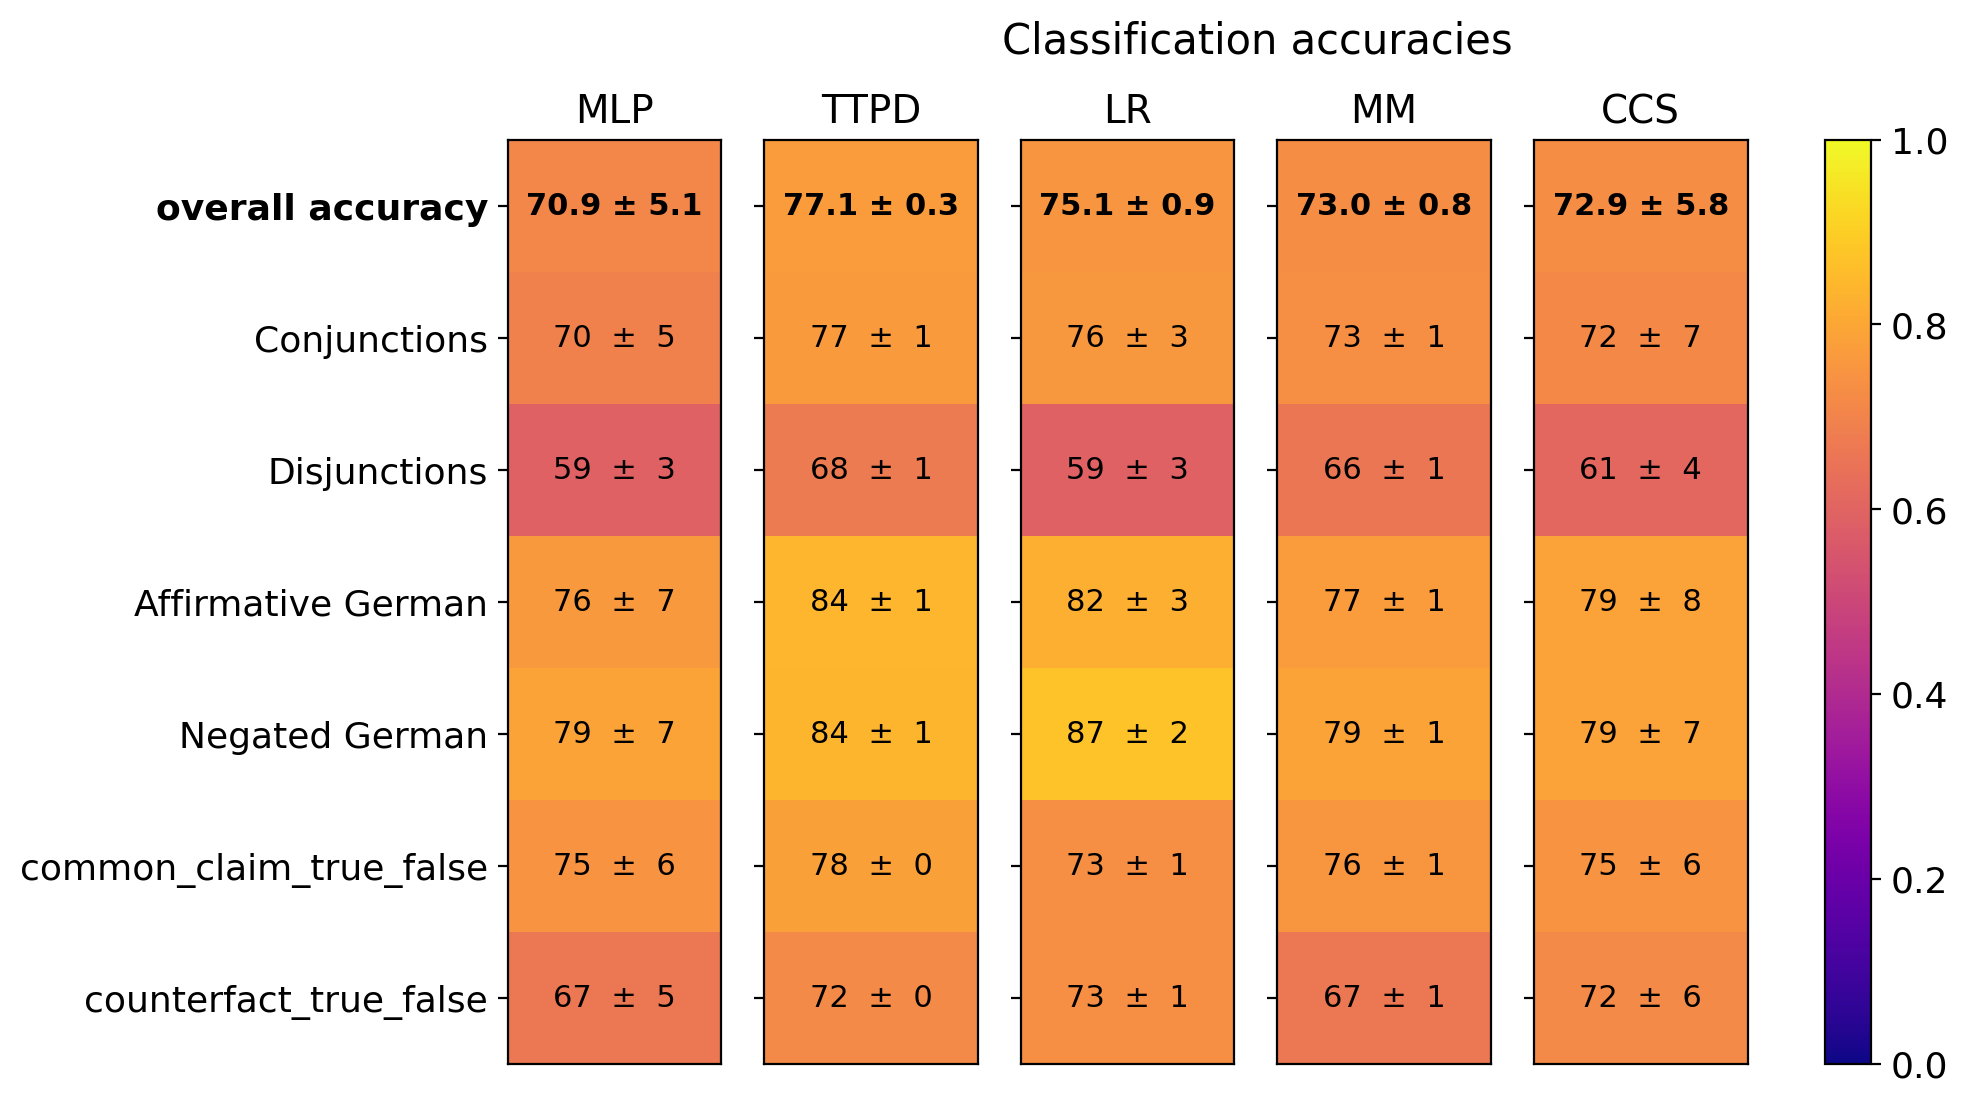

In [19]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=len(probe_names))
fig.suptitle("Classification accuracies", fontsize=15)

# build the overall‐accuracy lists once
overall_means = [probe_accuracies[probe]['mean'] for probe in probe_names]
overall_stds  = [probe_accuracies[probe]['std_dev']  for probe in probe_names]

for t, (ax, key) in enumerate(zip(axes, probe_names)):
    # build the per‐dataset grid
    grid = [[dataset_accuracies[key]['mean'][dataset]] for dataset in groups.keys()]
    grid_std = [[dataset_accuracies[key]['std'][dataset]] for dataset in groups.keys()]
    
    # insert the "overall" row at the top
    grid.insert(0, [overall_means[t]])
    grid_std.insert(0, [overall_stds[t]])

    # draw it
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # annotate
    for i, row in enumerate(grid):
        for j in range(len(row)):
            val = grid[i][j]
            std = grid_std[i][j]
            if i == 0:
                text = f"{val*100:3.1f} ± {std*100:3.1f}"
                weight = 'bold'
            else:
                text = f"{val*100:2.0f}  ± {std*100:2.0f}"
                weight = 'normal'
            ax.text(j, i, text, ha='center', va='center', fontsize=11, fontweight=weight)
    
    # ticks and titles
    ax.set_title(probe_names_short[t], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks(range(len(grid)))
    ax.set_yticklabels([])

# label the y‐axis on the first column only
yticks = ["overall accuracy"] + list(groups.keys())
axes[0].set_yticklabels(yticks, fontsize=13)
for label in axes[0].get_yticklabels():
    if label.get_text() == "overall accuracy":
        label.set_fontweight("bold")
    else:
        label.set_fontweight("normal")

# colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.ax.tick_params(labelsize=13)

# save the figure
plt.savefig(f"./results/{notebook_name}--{experiment_name}--{model_name}.svg", bbox_inches = "tight")

### Real world scenarios / lies

In [20]:
# Experiment hyperparameters
experiment_name = "real_world_lies"
validation_type = "separate validation sets"
val_sets = ["real_world_scenarios/all_unambiguous_replies",]
num_iter = 50   # number of times the probes are trained and evaluated on the same datasets

Either 
- a) load saved experimental results or 
- b) run a new training.

##### Train the probes

In [21]:
# Training and evaluating classifiers
    
## create an empty dictionary to store the results for each probe type
results = {probe:defaultdict(list) for probe in probe_names}
total_iterations = len(probe_types) * num_iter

## Iterate over each probe type and number of iterations
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_name in probe_names:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer)
            
            # train classifier
            if probe_name == "TTPD":
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_name == "LRProbe":
                probe = LRProbe.from_data(acts, labels)
            if probe_name == "CCSProbe":
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_name == "MMProbe":
                probe = MMProbe.from_data(acts, labels)
            if probe_name == "SimpleMLPProbe":
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on real world scenarios
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_name == "CCSProbe":
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_name][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers:   0%|          | 0/250 [00:00<?, ?it/s]

Training and evaluating classifiers: 100%|██████████| 250/250 [05:40<00:00,  1.36s/it]


In [22]:
# Compute and save summary statistics

probe_accuracies = compute_average_accuracies(results, num_iter)   # overall accuracies for each probe type
dataset_accuracies = compute_statistics(results)  # accuracies for each probe type and validation dataset
meta_info = {
    'notebook_name': notebook_name,
    'model_name': model_name,
    'layer': layer,
    'experiment_name': experiment_name,
    'probe_names': probe_names,
    'validation_type': validation_type,
    'num_iterations': num_iter,
    'train_sets': train_sets,
    'val_sets': val_sets,    
}   # Create a dictionary with meta information

show_and_save_results(probe_accuracies, dataset_accuracies, meta_info, save=True)

Results for the experiment 'real_world_lies' and the model 'Mistral_7B_chat' (layer 13):
    mean accuracy ± std deviation
------------------------------------
SimpleMLPProbe      : 83.4 ±  9.8%
TTPD                : 80.7 ±  4.5%
LRProbe             : 76.0 ±  7.7%
MMProbe             : 91.8 ±  1.6%
CCSProbe            : 80.8 ± 12.7%
------------------------------------

Results saved to ./results/lie_detection--real_world_lies--Mistral_7B_chat.json
